In [1]:
#
# This notebook is for the exploration of Logistic Regression -- it corresponds to Lecture Handout 2
#
# You will work in the associated Python module, 'lab_2.py'.

In [2]:
# Autoload setup (you don't need to edit this cell); instructions to: 
#   i) enable autoreloading of modules
%load_ext autoreload
#  ii) import the module 'lab_2' (which will contain your functions) in an autoreloadable way 
%aimport lab_2
# iii) indicate that we want autoreloading to happen on every evaluation.
%autoreload 1

In [3]:
##############################################################
#
# 1: Import modules.
#
##############################################################

import pandas as pd  # Pandas is a library for handling structured numerical data.
import numpy as np   # NumPy (Numerical Python), high-performance vector / matrix computations.

# SciKit-Learn is a module with utility function for data mining & machine learning.
import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix, classification_report, precision_score

# MatPlotLib provides MATLAB-style plotting utilities.
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.7

%matplotlib inline

In [4]:
##############################################################
#
# 2. Loading the ISLR 'Default' dataset
#
##############################################################

# see https://cran.r-project.org/web/packages/ISLR/ISLR.pdf
#
# This data set contains information on ten thousand bank customers. 
#
# The aim here is to predict which customers will default on their credit card debt.
#
# The dataset contains 10000 observations on the following 4 variables.
#   * 'default': a No/Yes label indicating whether the customer defaulted on their debt
#   * 'student': a No/Yes label indicating whether the customer is a student
#   * 'balance': the average balance that the customer has remaining on their credit card after making
#                their monthly payment
#   * 'income' : income of customer

# We use the 'pandas' package to read the CSV file into what Pandas calls a 'dataframe' (hence 'df').
df = pd.read_csv('Default.csv')

# Eyeball the first 10 observations to make sure the data has been loaded OK.  The 'Unnamed' column
# is the row number contained in the file.
df.head(10)

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625070
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138950
3,4,No,No,529.250605,35704.493940
4,5,No,No,785.655883,38463.495880
5,6,No,Yes,919.588530,7491.558572
6,7,No,No,825.513330,24905.226580
7,8,No,Yes,808.667504,17600.451340
8,9,No,No,1161.057854,37468.529290
9,10,No,No,0.000000,29275.268290


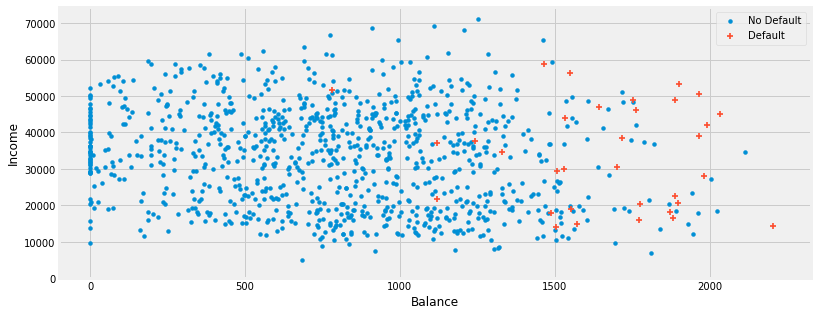

In [5]:
##############################################################
#
# 3. Visualise the data
#
##############################################################

# We need to visualise our data
# We will ignore the categorical feature 'student' and the row number in the first column.
# We'll focus first on the 'balance' and 'income' features.

balance = df['balance'].values
income = df['income'].values

# We'll convert the given outcomes (credit-card default or not) from string to boolean:
y = df['default'].values == 'Yes'

# We'll plot a subset of the data to keep the graph legible:
num_to_plot = 1000;
income_subset = income[0:num_to_plot];
balance_subset = balance[0:num_to_plot];
y_subset = y[0:num_to_plot];

# Set up matplotlib figure:
fig = plt.figure(figsize=(12,5))
ax = plt.gca()

# Scatter plot of balance vs income for the 'No Default' class
non_defaulters = y_subset == False; # Vector of bool, 'true' means non-defaulter
ax.scatter(balance_subset[non_defaulters], income_subset[non_defaulters], s=15, marker='o')

# Scatter plot of balance vs income for the 'Default' class
defaulters = y_subset == True; # Vector of bool, 'true' means defaulter
ax.scatter(balance_subset[defaulters],  income_subset[defaulters],  s=40, marker='+')

# Configure plot axes and labels:
ax.set_ylim(ymin=0)
ax.set_ylabel('Income')
ax.set_xlim(xmin=-100)
ax.set_xlabel('Balance')
ax.legend(['No Default', 'Default'])

# Peer into the scatter plot now in search of insight...
#
# Note that both defaulters and non-defaulters are well-distributed vertically; this 
# suggests that 'income' is not a great predictive factor.  On the other hand, the 
# defaulters are mostly in the high-balance region, and the non-defaulters are found
# in the low-balance region.  So 'balance' is the better candidate as a feature for class prediction.


In [6]:
# Having scrutinized the data, we start to implement a predictor (logistic classifier).

In [7]:
# Exercise 1: implement cross-entropy (in the lab_2 module)

w_test = np.array([0.1, 0.3])
X_test = np.array([[1,1], [1,0]])
y_test = np.array([0, 1])
print(lab_2.cross_entropy(w_test, X_test, y_test))

# Should print 0.77870375 (approx) if your function is working.

[0.59868766 0.52497919]
0.778706249732861


In [8]:
# Exercise 2: implement gradient computation (in the lab_2 module)
w_test = np.array([0.1, 0.3])
X_test = np.array([[1,1], [1,0]])
y_test = np.array([0, 1])
print(lab_2.gradient(w_test, X_test, y_test))
# Expected result: [ 0.06183342  0.29934383]

[0.06183342 0.29934383]


In [9]:
# The gradient descent algorithm as explained in page 22.
# The greek letter 'eta' in the slide is here denoted 'learning_rate'
# The method returns updated weights, and also a vector with the loss function evaluated at every 83rd iteration
# (83 was picked just to reduce the amount of data returned).
def gradient_descent(w0, X, y, learning_rate, maxit):
    w = w0
    loss = [];
    for i in range(0, maxit):
        if (i % 83 == 0):
            loss_error = lab_2.cross_entropy(w, X, y)
            loss.append(loss_error)
      
        grad = lab_2.gradient(w,X,y);
        w = w - learning_rate * grad;        
        i = i + 1
        
    return w, loss
        

In [10]:
#
# Setting up the Model and Design Matrix
#

# in this lab we will look at the following model:
# y = [ w0 + w1 * balance > 0]
#
# and ignore the 'income' feature

n = balance.shape[0]
p = 2

X = np.zeros(shape=(n, p))

# The first feature is just the value 1 (with associated weight w0); this captures the base rate.
X[:,0] = 1;

# The second feature is the balance values (with associated weight w1)
X[:,1] = balance[:]

# Gradient Descent algorithms are quite sensitive to initial conditions
# and it is often beneficial to rescale the features to improve the performance. 
#
# In our case we note that balance ranges from 0 to about 2500, which 
# is much larger in magnitude than the first feature (which is simply 1).
# We (arbitrarily) rescale by factor of 1/1000 to make the features be of comparable magnitude.

X[:,1] = X[:,1]/1000;


[0.5 0.5 0.5 ... 0.5 0.5 0.5]
[2.94583310e-05 4.89852904e-05 2.16759552e-04 ... 5.77030088e-05
 3.82686167e-03 1.37173145e-06]
[4.66001000e-04 1.00286000e-03 9.37117243e-03 ... 1.28350900e-03
 4.19338338e-01 4.56961179e-06]
[1.46926134e-04 2.96822742e-04 2.31756756e-03 ... 3.72261425e-04
 1.10147723e-01 2.11368433e-06]
[9.61942884e-05 1.90145870e-04 1.39391612e-03 ... 2.36807468e-04
 6.16872068e-02 1.57858339e-06]
[4.45727668e-04 9.56742523e-04 8.87592757e-03 ... 1.22346860e-03
 4.02487169e-01 4.44041375e-06]
[7.37934656e-04 1.61018768e-03 1.55936652e-02 ... 2.06984714e-03
 5.67116296e-01 6.64558330e-06]
[4.78405150e-04 1.04169365e-03 1.00676456e-02 ... 1.33824314e-03
 4.53462171e-01 4.37043342e-06]
[4.38919382e-04 9.34850045e-04 8.48112319e-03 ... 1.19249532e-03
 3.81087411e-01 4.58234610e-06]
[2.25651405e-06 3.35333473e-06 1.06819770e-05 ... 3.80966827e-06
 1.00243811e-04 2.06986089e-07]
[4.29899716e-04 9.27941409e-04 8.75116738e-03 ... 1.18877875e-03
 4.06641293e-01 4.14101260e-06]


[4.15438975e-05 7.71246441e-05 4.70885848e-04 ... 9.41302394e-05
 1.53192828e-02 9.95631074e-07]
[2.27602379e-04 4.77318325e-04 4.15171989e-03 ... 6.05868318e-04
 2.15422403e-01 2.61213433e-06]
[2.03401241e-04 4.20270510e-04 3.50173527e-03 ... 5.30912430e-04
 1.75422553e-01 2.55376714e-06]
[9.77933370e-07 1.44005201e-06 4.46624670e-06 ... 1.63120977e-06
 3.98043594e-05 9.47882896e-08]
[5.91839509e-04 1.30836279e-03 1.31856695e-02 ... 1.68899110e-03
 5.43086755e-01 4.93058055e-06]
[9.40363498e-05 1.80256748e-04 1.20805296e-03 ... 2.22281756e-04
 4.56951339e-02 1.85734383e-06]
[6.19129760e-04 1.36823164e-03 1.37694404e-02 ... 1.76607343e-03
 5.53536234e-01 5.16754443e-06]
[5.44756334e-04 1.19288533e-03 1.17061241e-02 ... 1.53523714e-03
 4.99536732e-01 4.80782455e-06]
[2.57797215e-06 3.94818135e-06 1.37349567e-05 ... 4.52918585e-06
 1.52808163e-04 1.97197174e-07]
[5.05251092e-04 1.11673795e-03 1.12646653e-02 ... 1.44156490e-03
 5.02933025e-01 4.21622114e-06]
[6.84441921e-05 1.33195390e-04

[2.69010326e-04 4.37005623e-04 1.80472355e-03 ... 5.10912495e-04
 2.73305071e-02 1.44107391e-05]
[1.17551280e-03 2.10392445e-03 1.14685904e-02 ... 2.53743111e-03
 2.38475136e-01 3.49734880e-05]
[2.69010326e-04 4.37005623e-04 1.80472355e-03 ... 5.10912495e-04
 2.73305071e-02 1.44107391e-05]
[1.17551280e-03 2.10392445e-03 1.14685904e-02 ... 2.53743111e-03
 2.38475136e-01 3.49734880e-05]
[2.69010326e-04 4.37005623e-04 1.80472355e-03 ... 5.10912495e-04
 2.73305071e-02 1.44107391e-05]
[1.17551280e-03 2.10392445e-03 1.14685904e-02 ... 2.53743111e-03
 2.38475136e-01 3.49734880e-05]
[2.69010326e-04 4.37005623e-04 1.80472355e-03 ... 5.10912495e-04
 2.73305071e-02 1.44107391e-05]
[1.17551280e-03 2.10392445e-03 1.14685904e-02 ... 2.53743111e-03
 2.38475136e-01 3.49734880e-05]
[2.69010326e-04 4.37005623e-04 1.80472355e-03 ... 5.10912495e-04
 2.73305071e-02 1.44107391e-05]
[1.17551280e-03 2.10392445e-03 1.14685904e-02 ... 2.53743111e-03
 2.38475136e-01 3.49734880e-05]
[2.69010326e-04 4.37005623e-04

[1.53941410e-03 2.45167274e-03 9.52038717e-03 ... 2.84781987e-03
 1.18249634e-01 9.26332104e-05]
[1.52745952e-03 2.43446428e-03 9.47451180e-03 ... 2.82851712e-03
 1.18181367e-01 9.14997995e-05]
[1.51617700e-03 2.41821062e-03 9.43107930e-03 ... 2.81028076e-03
 1.18116227e-01 9.04349558e-05]
[1.50552292e-03 2.40285097e-03 9.38994350e-03 ... 2.79304334e-03
 1.18054072e-01 8.94337588e-05]
[1.49545707e-03 2.38832917e-03 9.35096849e-03 ... 2.77674247e-03
 1.17994767e-01 8.84917160e-05]
[1.48594229e-03 2.37459324e-03 9.31402776e-03 ... 2.76132039e-03
 1.17938182e-01 8.76047180e-05]
[1.47694423e-03 2.36159500e-03 9.27900344e-03 ... 2.74672356e-03
 1.17884192e-01 8.67689995e-05]
[1.46843104e-03 2.34928979e-03 9.24578560e-03 ... 2.73290228e-03
 1.17832678e-01 8.59811052e-05]
[1.46037324e-03 2.33763611e-03 9.21427158e-03 ... 2.71981036e-03
 1.17783528e-01 8.52378591e-05]
[1.45274342e-03 2.32659537e-03 9.18436545e-03 ... 2.70740482e-03
 1.17736633e-01 8.45363376e-05]
[1.44551611e-03 2.31613166e-03

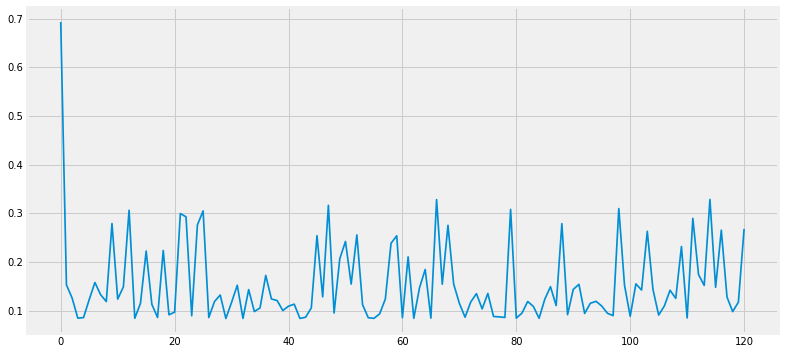

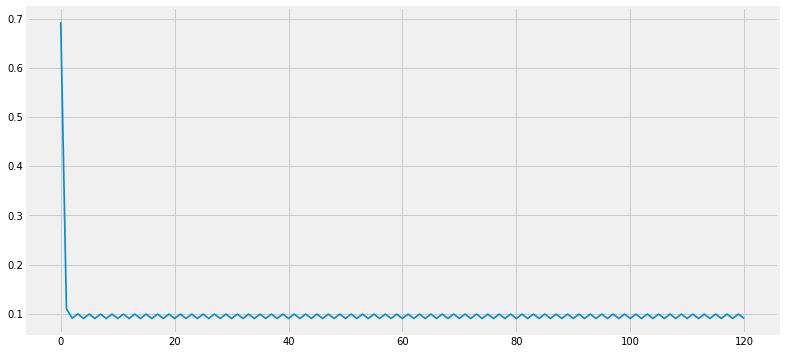

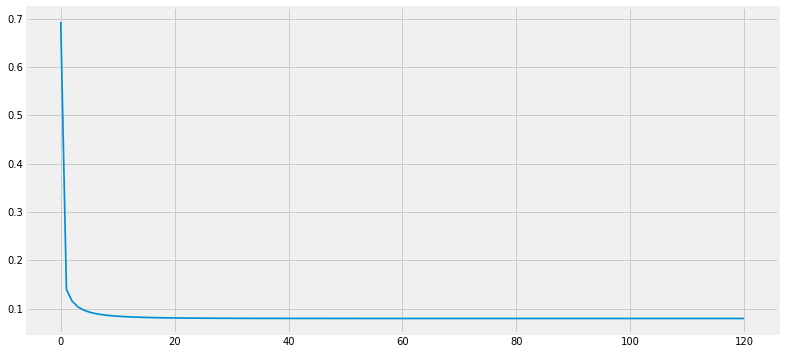

In [11]:
# In the following we are studying the convergence for 3 different learning rates
# This cell might take a while to evaluate!

w0 = [0, 0];
w, loss = gradient_descent(w0, X, y, learning_rate=50, maxit=10000);
print(w)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(loss)

w0 = [0, 0];
w, loss = gradient_descent(w0, X, y, learning_rate=30, maxit=10000);
print(w)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(loss)

w0 = [0, 0];
w, loss = gradient_descent(w0, X, y, learning_rate=1, maxit=10000);
print(w)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(loss)

In [12]:
# Question 3: What is the best learning rate value out of 50, 30 and 1?
# Look at the graphs above to see.  Return your answer from the 'question_3' function in 'lab_2.py'

In [13]:
# A good way to check that if you reached convergence is to check if the gradient is null (or at least very small):
lab_2.gradient(w, X, y)

array([ 6.54752947e-06, -3.96283037e-06])

In [14]:
# In Logistic Regression, we set a parametric model for the likelihood.
# We denote logit = x'w and parametrise the likelihood as
# p(y_i|logit) = 1/(1 + exp(-logit))
#
# We want to verify that this is a correct approximation for our problem
#
# The following function makes an empirical measurement of p(y_i|logit)
# by recording in the dataset the proportion of default=True for 
# a particular logit value (within some small threshold T).
def get_empirical_probability(logit, logits_train, y, T=1):
    valid = ((logits_train <= logit + T) * (logits_train >= logit - T));    
    n_defaults = sum(valid[y==True]);
    n_nodefaults = sum(valid[y==False]);
    empirical_prob = n_defaults / (n_defaults + n_nodefaults);
    return empirical_prob

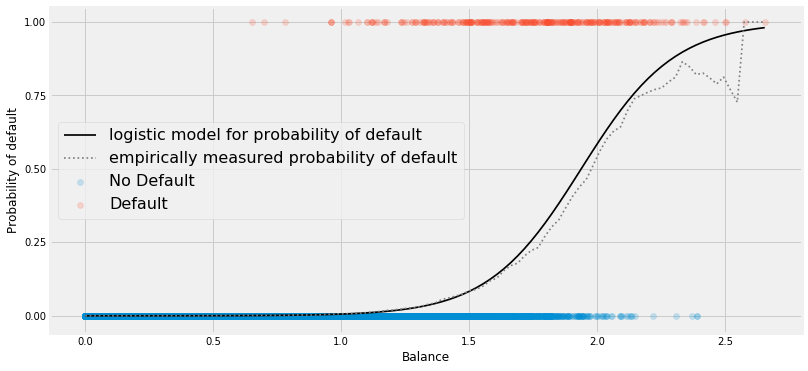

In [15]:
# Testing set: predict the probability of default for 100 values of balance.

n_test = 100
X_test = np.zeros(shape=(n_test,2))
X_test[0:n_test,0] = 1;
X_test[0:n_test,1] = np.linspace(X[:,1].min(), X[:,1].max(), num=n_test)

p_test = lab_2.predict(w, X_test)

# we compute the logit values and their corresponding empirical probabilities of default
logits_test = lab_2.logit(w, X_test)
logits_train = lab_2.logit(w, X)
p_empirical = [get_empirical_probability(logit, logits_train, y) for logit in logits_test ];

# plot the graphs
fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.scatter(X[y==False,1], y[y==False], alpha= 0.2)
ax.scatter(X[y==True,1], y[y==True], alpha= 0.2)
ax.plot(X_test[:,1], p_test, color='black')
ax.plot(X_test[:,1], p_empirical, ':', color='gray')

ax.set_ylabel('Probability of default');
ax.set_xlabel('Balance');
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.]);
ax.legend(['logistic model for probability of default',
           'empirically measured probability of default', 
           'No Default', 'Default'],  prop={'size': 16})


In [19]:
# At this point, we still don't have a classifier. 
# But all we need is to set a threshold on the predicted probabilities.
#
# Exercise 4:
# Flesh out the function 'predict_class' in the module to give
# the predicted class for observations X and weights w.

# Use that function here to assess the accuracy of the classifier
# for different thresholds.

# Accuracy = percentage correctly classified.
def accuracy(w, X, y, threshold):
    return np.mean(y == lab_2.predict_class(w, X, threshold))

w = np.array([-10.63971053,   5.49188453])   # These are good weights!
print(accuracy(w, X, y, 0.25))
print(accuracy(w, X, y, 0.5))
print(accuracy(w, X, y, 0.75))
print(accuracy(w, X, y, 0.95))

# Update your module function 'question_5' to report the accuracy for a threshold of 0.5.

0.9653
0.9725
0.9698
0.9671
